## Explain the loss for an NHANES model - simulate a change in the way weight is measured

Here we switch weight to be measured in pounds rather than kilograms for release cycles 7 and 8 in the test set

**Question of interest**: Can we identify this simulated domain shift?

In [3]:
from sklearn.metrics import log_loss, roc_auc_score
from xgboost import XGBClassifier

import matplotlib.pylab as plt
import numpy as np

import matplotlib
import pickle
import shap
import os

from deepshap.data import load_nhanes_new

# Name of experiment we are running
exp_name = "weight_shift"

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_nhanes_new()

# Train or load model
mpath = "models/{}_xgb.p".format(exp_name)
if not os.path.exists(mpath):
    model = XGBClassifier()
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
              early_stopping_rounds=10, verbose=False)
    pickle.dump(model, open(mpath,"wb"))
else:
    model = pickle.load(open(mpath,"rb"))
    
# Evaluate model performance
print("Train ROC AUC ", roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
print("Test ROC AUC  ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print("Train loss    ", log_loss(y_train, model.predict_proba(X_train)[:,1]))
print("Test loss     ", log_loss(y_test, model.predict_proba(X_test)[:,1]))

Train ROC AUC  0.9882752748310369
Test ROC AUC   0.8681190191906044
Train loss     0.08771404129969228
Test loss      0.26650387368177847


#### Induce covariate shift

Shifted Test ROC AUC   0.860024830568288


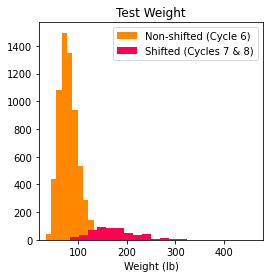

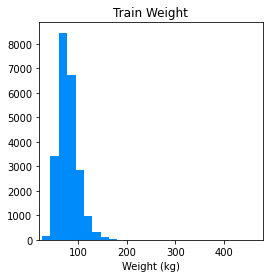

In [6]:
kg_to_pounds = 2.20462
X_test2      = X_test.copy()
shift_ind    = "Examination_Weight"
release_cyc  = X_test["Demographics_ReleaseCycle"]>=7
X_test2.loc[release_cyc, shift_ind] = X_test2.loc[release_cyc, shift_ind]*kg_to_pounds
print("Shifted Test ROC AUC  ", roc_auc_score(y_test, model.predict_proba(X_test2)[:,1]))
# print("Shifted Test accuracy ", model.score(X_test2, y_test))

plt.hist(X_test2["Examination_Weight"][np.invert(release_cyc)],20,label="Non-shifted (Cycle 6)", color="#ff8800")
plt.hist(X_test2["Examination_Weight"][release_cyc],20,label="Shifted (Cycles 7 & 8)", color="#ff0052")
plt.title("Test Weight")
plt.xlabel("Weight (lb)")
plt.xlim([20,480])
plt.legend()
plt.gcf().set_size_inches(4, 4)
plt.savefig("fig/{}_test_weight.pdf".format(exp_name))
plt.show()

plt.hist(X_train["Examination_Weight"],20,color="#008bfb")
plt.title("Train Weight")
plt.xlabel("Weight (kg)")
plt.xlim([20,480])
plt.gcf().set_size_inches(4, 4)
plt.savefig("fig/{}_train_weight.pdf".format(exp_name))
plt.show()

### Load/compute attributions

In [7]:
###############################
### Get output attributions ###
###############################
train_attr_path = "attr/{}_train_attr.npy".format(exp_name)
test_attr_path  = "attr/{}_test_attr.npy".format(exp_name)
test2_attr_path = "attr/{}_test2_attr.npy".format(exp_name)

np.random.seed(102190)
rand_inds = np.random.choice(range(X_train.shape[0]), 1000, replace=False)
reference = X_train.iloc[rand_inds]

explainer = shap.TreeExplainer(model, data=reference)
if not (os.path.exists(train_attr_path) and 
        os.path.exists(test_attr_path) and 
        os.path.exists(test2_attr_path)):
    train_attr = explainer.shap_values(X_train)
    test_attr  = explainer.shap_values(X_test)
    test2_attr = explainer.shap_values(X_test2)
    
    np.save(train_attr_path, train_attr)
    np.save(test_attr_path, test_attr)
    np.save(test2_attr_path, test2_attr)
else:
    train_attr = np.load(train_attr_path)
    test_attr  = np.load(test_attr_path)
    test2_attr = np.load(test2_attr_path)

#############################
### Get loss attributions ###
#############################
train_loss_attr_path = "attr/{}_train_loss_attr.npy".format(exp_name)
test_loss_attr_path  = "attr/{}_test_loss_attr.npy".format(exp_name)
test2_loss_attr_path = "attr/{}_test2_loss_attr.npy".format(exp_name)

loss_explainer = shap.TreeExplainer(model, data=reference, model_output="log_loss")
if not (os.path.exists(train_loss_attr_path) and 
        os.path.exists(test_loss_attr_path) and
        os.path.exists(test2_loss_attr_path)):
    train_loss_attr = loss_explainer.shap_values(X_train, y_train)
    test_loss_attr  = loss_explainer.shap_values(X_test, y_test)
    test2_loss_attr = loss_explainer.shap_values(X_test2, y_test)
    
    np.save(train_loss_attr_path, train_loss_attr)
    np.save(test_loss_attr_path, test_loss_attr)
    np.save(test2_loss_attr_path, test2_loss_attr)
else:
    train_loss_attr = np.load(train_loss_attr_path)
    test_loss_attr  = np.load(test_loss_attr_path)
    test2_loss_attr  = np.load(test2_loss_attr_path) 

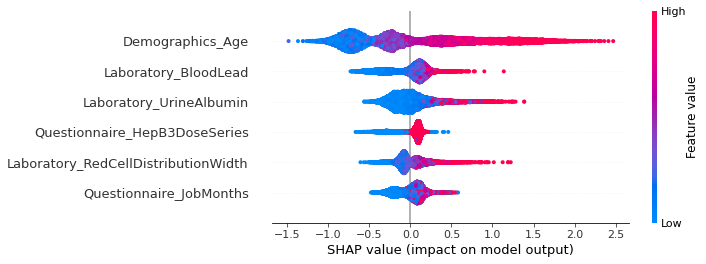

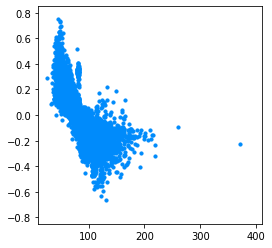

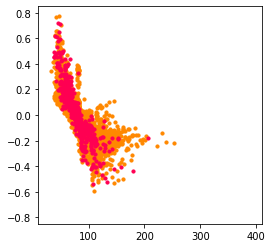

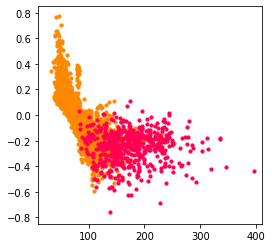

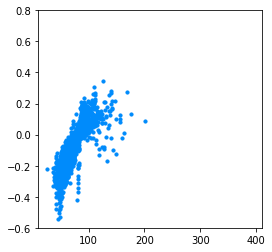

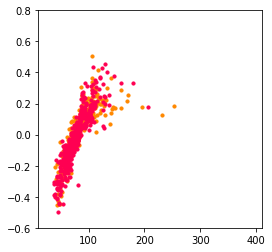

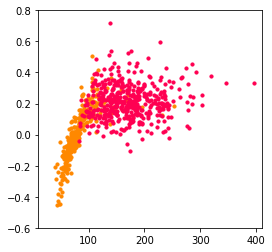

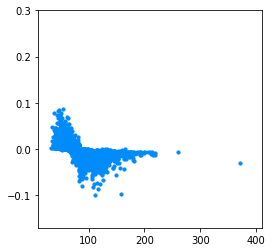

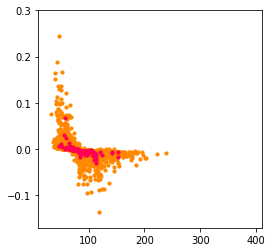

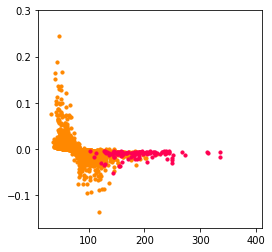

In [28]:
import matplotlib.pylab as plt
import shap

def dep_plot(attr, featvals, title, is_save=False, xlim=None, ylim=None, is_test=False):
    col_ind = list(featvals.columns).index(col_name)
    if is_test:
        early_inds = featvals["Demographics_ReleaseCycle"]<7
        late_inds  = featvals["Demographics_ReleaseCycle"]>=7
        vals = featvals[col_name]
        plt.scatter(vals.loc[early_inds], attr[early_inds,col_ind], s=10, 
                    color="#ff8800", rasterized=True)
        plt.scatter(vals.loc[late_inds], attr[late_inds,col_ind], s=10, 
                    color="#ff0052", rasterized=True)
    else:
        plt.scatter(featvals[col_name], attr[:,col_ind], s=10, 
                    color="#008bfb", rasterized=True)
    plt.xlim(xlim)
    plt.ylim(ylim)
#     shap.dependence_plot(col_name, attr, featvals, interaction_index=None, 
#                          show=False, xmin=0, xmax=400)
#     shap.dependence_plot(col_name, attr, featvals, interaction_index=int_name, show=False)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(4, 4)
#     plt.title(title)
    
    if is_save:
        fig_name = "fig/{}_{}_{}.pdf".format(exp_name, title, col_name)
        plt.savefig(fig_name)
        
    plt.show()
    
is_save = True

col_name = "Examination_Weight"
int_name = "Demographics_ReleaseCycle"

###########################
### Output explanations ###
###########################
shap.summary_plot(train_attr, X_train, max_display=6)
xlim = [10,410]
ylim = [-.85,.85]
dep_plot(train_attr, X_train, "model_output_train", is_save=is_save, xlim=xlim, ylim=ylim)
dep_plot(test_attr, X_test, "model_output_test", is_save=is_save, xlim=xlim, ylim=ylim, is_test=True)
dep_plot(test2_attr, X_test2, "model_output_test2", is_save=is_save, xlim=xlim, ylim=ylim, is_test=True)

#########################
### Loss explanations ###
#########################
# Attributions for positive samples
ylim = [-.6,.8]
dep_plot(train_loss_attr[y_train == 1], X_train[y_train == 1], 
         "model_loss_train_y1", is_save=is_save, xlim=xlim, ylim=ylim)
dep_plot(test_loss_attr[y_test == 1], X_test[y_test == 1], 
         "model_loss_test_y1", is_save=is_save, xlim=xlim, ylim=ylim, is_test=True)
dep_plot(test2_loss_attr[y_test == 1], X_test2[y_test == 1], 
         "model_loss_test2_y1", is_save=is_save, xlim=xlim, ylim=ylim, is_test=True)

# Attributions for negative samples
ylim = [-.17, .3]
dep_plot(train_loss_attr[y_train == 0], X_train[y_train == 0], 
         "model_loss_train_y0", is_save=is_save, xlim=xlim, ylim=ylim)
dep_plot(test_loss_attr[y_test == 0], X_test[y_test == 0], 
         "model_loss_test_y0", is_save=is_save, xlim=xlim, ylim=ylim, is_test=True)
dep_plot(test2_loss_attr[y_test == 0], X_test2[y_test == 0], 
         "model_loss_test2_y0", is_save=is_save, xlim=xlim, ylim=ylim, is_test=True)

In [23]:
X_test2[y_test == 1]["Demographics_ReleaseCycle"]

28825    6.0
28877    6.0
28902    6.0
28904    6.0
28914    6.0
        ... 
46918    8.0
46956    8.0
47037    8.0
47104    8.0
47156    8.0
Name: Demographics_ReleaseCycle, Length: 827, dtype: float64